In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import integrate
import scipy.linalg as la
import scipy.sparse.linalg as sla

In [29]:
k = 9
m = 1
T = 2 * np.pi * ((k/m)**0.5)
omega = 2 * np.pi / T
N = 1e4
R0 = [0.5, 1.]
T = 2 * np.pi * ((k/m)**0.5)
t0, t1 = 0, 5 * T
t = np.linspace(t0, t1, 10000)
R = np.zeros((len(t), len(R0)), dtype=np.float64)

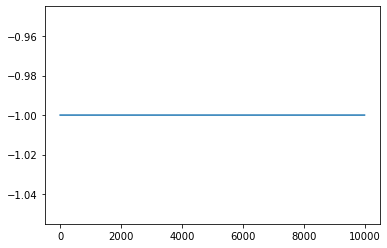

In [30]:
En = np.array([1/2 * k * R[:, 1][i]**2 + 1/2 * m * R[:, 0][i]**2 for i in range(len(R[:, 0]))])
E0 = 1/2 * k * R0[1]**2 + 1/2 * m * R0[0]**2
plt.plot(np.linspace(0, len(En), len(En)), (En - E0) / E0)

In [31]:
def osc1(t, z):
    omega = 3
    gamma = 0.5
    dy = np.zeros(2)
    dy[0] = z[1]
    dy[1] = (-1 * (omega)**2) * z[0] - gamma * z[1]
    
    return dy

In [32]:
def osc2(t, z):
    omega = 3
    gamma = 0.5
    A0 = 1
    omegaF = 2
    F = A0 * np.cos(omegaF * t)
    dy = np.zeros(2)
    dy[0] = z[1]
    dy[1] = (-1 * (omega)**2) * z[0] - gamma * z[1] + F
    
    return dy

In [41]:
def f1(R0, oscillator):
    N = 1e4
    t0, t1 = 0, 5 * T

    t = np.linspace(t0, t1, 10000)
    
    R = np.zeros((len(t), len(R0)), dtype=np.float64)
    R[0, :] = R0
    
    r = integrate.ode(oscillator).set_integrator("dopri5")
    r.set_initial_value(R0, t0)
    
    for i in range(1, t.size):
        R[i, :] = r.integrate(t[i])
        if not r.successful():
            raise RuntimeError("Could not integrate")

            
    fig, axs = plt.subplots(3, 1, figsize=(8,8))
    axs[0].plot(t, R[:,0])
    axs[1].plot(t, R[:,1])
    axs[2].plot(R[:, 0], R[:,1])

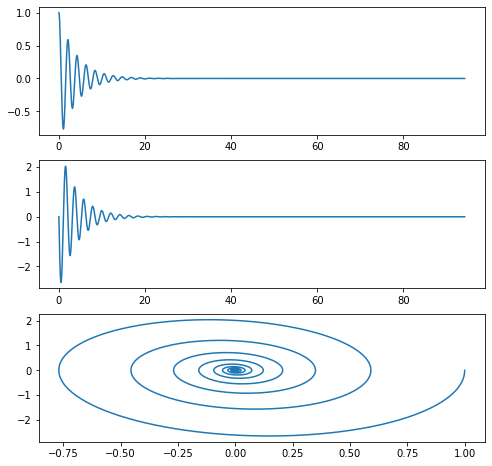

In [42]:
R0 = [1, 0]
f1(R0, osc1)

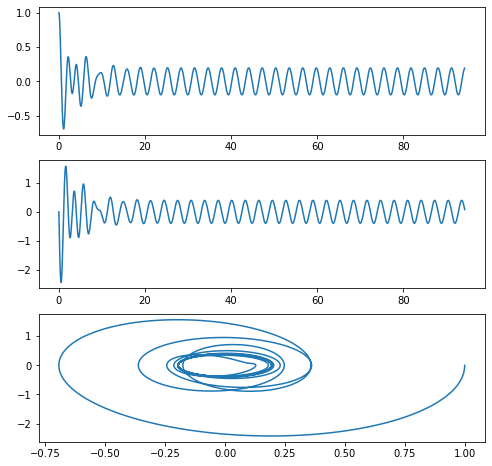

In [43]:
R0 = [1, 0]
f1(R0, oscillator2)

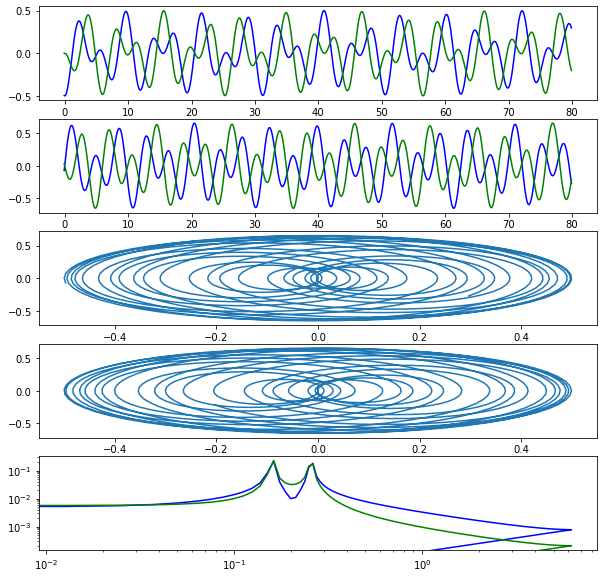

In [52]:
N = 2
m = [1, 1]
k = [1, 0.8, 1]
R0 = np.array([-0.5, 0])
v0 = np.array([0, 0])

omega = np.zeros((N+1, N), dtype=np.float64)

for alpha in range(N+1):
    for beta in range(N):
        omega[alpha, beta] = k[alpha] / m[beta]
        
Omega = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    if i == 0:
        Omega[i, i] = omega[0, 0] + omega[1, 0]
        Omega[0, 1] = -omega[1, 0]
        
    if i > 0:
        if i < N-1:
            Omega[i, i-1] = -omega[i, i]
            Omega[i,i] = omega[i, i] + omega[i + 1, i]
            Omega[i, i+1] = -omega[i+1, i]
        else:
            Omega[i, i-1] = -omega[i, i]
            Omega[i, i] = omega[i, i] + omega[i + 1, i]
            
Theta, Sigma = np.linalg.eig(Omega)

Theta = np.sqrt(Theta)
SigmaV = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    for j in range(N):
        SigmaV[j, i] = -Theta[i] * Sigma[j, i]
        
C1 = np.dot(np.linalg.inv(Sigma),R0[None].T.conj())
C2 = np.dot(np.linalg.inv(SigmaV),v0[None].T.conj())

C = np.sqrt(C1**2 + C2**2)

alpha = np.zeros(N, dtype=np.float64)

for i in range(N):
    if C[i] == 0:
        alpha[i] = 0
    else:
        alpha[i] = np.arctan(C2[i]/C1[i])
        
        if C1[i] < 0:
            alpha[i] = np.pi + alpha[i]
            
        if C1[i] > 0:
            if C2[i] < 0:
                alpha[i] = 2 * np.pi + alpha[i]

N = len(Omega)
N1 = int(1000)
Tmax = 80
t = np.zeros(N1, dtype=np.float64)

X = np.zeros((N, N1), dtype=np.float64)
Xv = np.zeros((N, N1), dtype=np.float64)

for j in range(N1):
    t[j] = (j-1)/(N1-1)*Tmax
    
for j in range(N1):
    s = np.zeros(N, dtype=np.float64)
    
    for i in range(N):
        s = s + C[i] * Sigma[:,i] * np.cos(Theta[i]*t[j] + alpha[i])
        
    X[:, j] = s
    
for j in range(N1):
    s = np.zeros(N, dtype=np.float64)
    
    for i in range(N):
        s = s + C[i] * Sigma[:,i] * Theta[i] * np.sin(Theta[i]*t[j] + alpha[i])
        
    Xv[:, j] = -s
    
c1 = np.fft.fft(X[0])
c2 = np.fft.fft(X[1])

Cm1 = np.zeros(N1 // 2, dtype=np.float64)
Cm2 = np.zeros(N1 // 2, dtype=np.float64)
Freq = np.zeros(N1 // 2, dtype=np.float64)

for j in range(1, N1//2):
    Cm1[j-1] = abs(c1[j-1]) / (N1/2)
    Cm2[j-1] = abs(c2[j-1]) / (N1/2)
    Freq[j-1] = (j-1) / Tmax    

fig, axs = plt.subplots(5, 1, figsize=(10,10))
axs[0].plot(t, X[0],'blue', t, X[1],'green')
axs[1].plot(t, Xv[0],'blue', t, Xv[1],'green')
axs[2].plot(X[0], Xv[0])
axs[3].plot(X[1], Xv[1])

axs[4].set_xscale('log')
axs[4].set_yscale('log')   

axs[4].plot(Freq, Cm1,'blue', Freq, Cm2,'green')

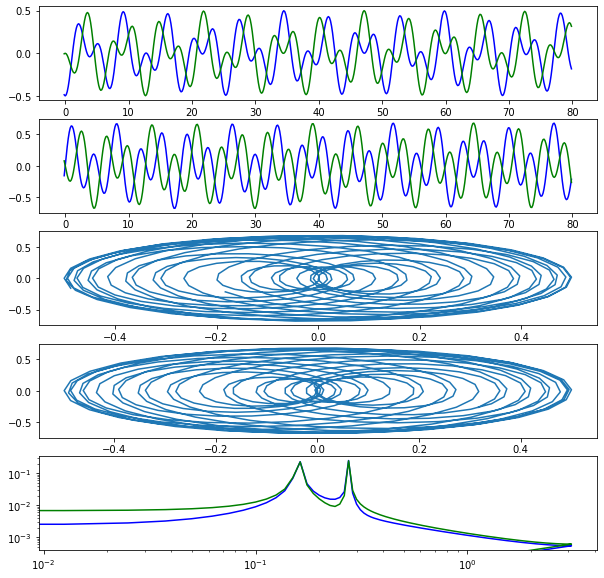

In [55]:
N = 2
m = [1, 1]
k = [1, 1, 1]
R0 = np.array([-0.5, 0])
v0 = np.array([0, 0])

omega = np.zeros((N+1, N), dtype=np.float64)

for alpha in range(N+1):
    for beta in range(N):
        omega[alpha, beta] = k[alpha] / m[beta]
        
Omega = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    if i == 0:
        Omega[i, i] = omega[0, 0] + omega[1, 0]
        Omega[0, 1] = -omega[1, 0]
        
    if i > 0:
        if i < N-1:
            Omega[i, i-1] = -omega[i, i]
            Omega[i,i] = omega[i, i] + omega[i+1, i]
            Omega[i, i+1] = -omega[i+1, i]
        else:
            Omega[i, i-1] = -omega[i, i]
            Omega[i, i] = omega[i, i] + omega[i+1, i]
            
Theta, Sigma = np.linalg.eig(Omega)

Theta = np.sqrt(Theta)
SigmaV = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    for j in range(N):
        SigmaV[j, i] = -Theta[i] * Sigma[j, i]
        
C1 = np.dot(np.linalg.inv(Sigma),R0[None].T.conj())
C2 = np.dot(np.linalg.inv(SigmaV),v0[None].T.conj())

C = np.sqrt(C1**2 + C2**2)

alpha = np.zeros(N, dtype=np.float64)

for i in range(N):
    if C[i] == 0:
        alpha[i] = 0
    else:
        alpha[i] = np.arctan(C2[i] / C1[i])
        
        if C1[i] < 0:
            alpha[i] = np.pi + alpha[i]
            
        if C1[i] > 0:
            if C2[i] < 0:
                alpha[i] = 2 * np.pi + alpha[i]

N = len(Omega)
N1 = int(500)
Tmax = 80
t = np.zeros(N1, dtype=np.float64)

X = np.zeros((N, N1), dtype=np.float64)
Xv = np.zeros((N, N1), dtype=np.float64)

for j in range(N1):
    t[j] = (j-1) / (N1-1) * Tmax
    
for j in range(N1):
    s = np.zeros(N, dtype=np.float64)
    
    for i in range(N):
        s = s + C[i] * Sigma[:,i] * np.cos(Theta[i]*t[j] + alpha[i])
        
    X[:, j] = s
    
for j in range(N1):
    s = np.zeros(N, dtype=np.float64)
    
    for i in range(N):
        s = s+ C[i] * Sigma[:,i] * Theta[i] * np.sin(Theta[i]*t[j] + alpha[i])
        
    Xv[:, j] = -s
    
A1 = np.fft.fft(X[0])
A2 = np.fft.fft(X[1])    

C1 = np.zeros(N1 // 2, dtype=np.float64)
C2 = np.zeros(N1 // 2, dtype=np.float64)
Freq = np.zeros(N1 // 2, dtype=np.float64)

for j in range(1, N1 // 2):
    C1[j-1] = abs(A1[j-1]) / (N1/2)
    C2[j-1] = abs(A2[j-1]) / (N1/2)
    Freq[j-1] = (j-1) / Tmax
    
fig, axs = plt.subplots(5, 1, figsize=(10,10))
axs[0].plot(t, X[0],'blue', t, X[1],'green')
axs[1].plot(t, Xv[0],'blue', t, Xv[1],'green')
axs[2].plot(X[0], Xv[0])
axs[3].plot(X[1], Xv[1])

axs[4].set_xscale('log')
axs[4].set_yscale('log')   

axs[4].plot(Freq, Cm1,'blue', Freq, Cm2,'green')